In [1]:
# imports
%reload_ext autoreload
%autoreload 2
%matplotlib inline 

from utils.basic_utils import *
from utils.pricing import *
from utils.imports import *
from utils.structured import *

import matplotlib.pyplot as plt
from IPython.display import display

Loading utils/config.json
Loading file quote/csv/2019-02-26
Loading file summary-categories/assetProfile


In [2]:
def display_all(df):
    with pd.option_context("display.max_rows", 1000, "display.max_columns", 1000): 
        display(df)

In [6]:
symbol = '^VIX'
# excl_list = ['ORBK']
# profile.drop(profile[profile.symbol.isin(excl_list)].index, inplace=True)

In [7]:
PATH = './'
!ls {PATH}

ds_macro_vix.ipynb macro-vix-raw      tmp                utils


### Get universe pricing

In [8]:
# Load pricing, refresh once
symbols_list = config['benchmarks'] + config['risk']
%time px_set = get_mults_pricing(symbols_list, freq, 'close')

Retrieved pricing for ^DJI
Retrieved pricing for ^IXIC
Retrieved pricing for ^GSPC
Retrieved pricing for ^RUT
Retrieved pricing for ^VIX
CPU times: user 155 ms, sys: 15.4 ms, total: 171 ms
Wall time: 912 ms


In [9]:
risk_symbol = '^VIX'
bench_symbol = '^GSPC'

In [231]:
# All daily pricing is downloaded for 10 years by default
get_pricing('^VIX', '1d', '30y');
get_pricing('^GSPC', '1d', '30y');

Getting pricing interval of ^VIX interval: 1d, range: 30y
Getting pricing interval of ^GSPC interval: 1d, range: 30y


In [13]:
# Retrieves historical pricing
secpx = get_symbol_pricing('^VIX', freq)
secpx.rename(columns={'close': risk_symbol}, inplace=True)
secpx.drop(columns=['volume'], inplace=True)
secpx.set_index(secpx.index.astype(np.datetime64), inplace=True)

closepx = secpx[risk_symbol]
openpx = secpx['open']
lowpx = secpx['low']
highpx = secpx['high']

closepx_1d_shift = closepx.shift(1)
pct_chg = closepx.pct_change()

SPY = get_symbol_pricing('^GSPC', freq) # SPY pricing
SPY.set_index(SPY.index.astype(np.datetime64), inplace=True)

secpx[bench_symbol] = SPY['close']
SPY_close = secpx[bench_symbol]
SPY_pct_chg = secpx[bench_symbol].pct_change()

### Feature construction

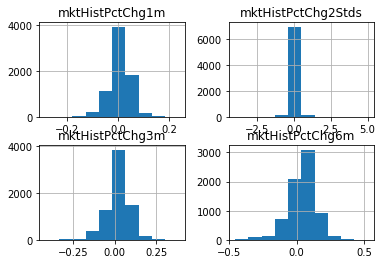

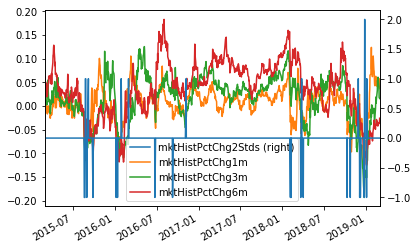

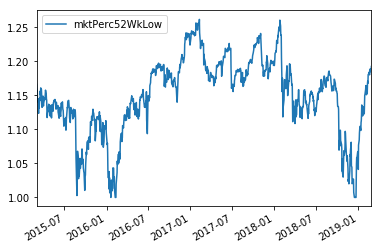

In [14]:
# historical returns for 1, 3, and 6 months
secpx['mktHistPctChg2Stds'] = SPY_pct_chg.apply(sign_compare, args=(SPY_pct_chg.std() * 2,))
secpx['mktHistPctChg1m'] = SPY_close.pct_change(periods=20)
secpx['mktHistPctChg3m'] = SPY_close.pct_change(periods=60)
secpx['mktHistPctChg6m'] = SPY_close.pct_change(periods=120)
secpx['mktPerc52WkLow'] = (SPY_close / SPY_close.rolling(252).min())

show = ['mktHistPctChg2Stds', 'mktHistPctChg1m', 'mktHistPctChg3m', 
        'mktHistPctChg6m']
secpx[show].hist();
secpx[show].tail(252*4).plot(secondary_y='mktHistPctChg2Stds');
show = ['mktPerc52WkLow']
secpx[show].tail(252*4).plot();

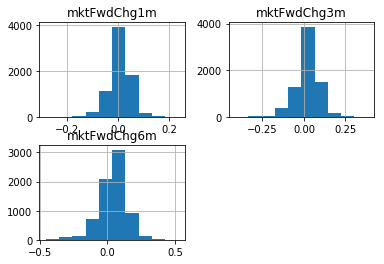

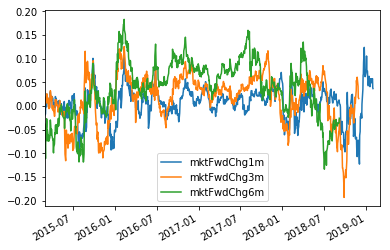

In [15]:
# Forward returns, 1w, 1m, 3m
SPY_close.pct_change(5).shift(-5)
secpx['mktFwdChg1m'] = SPY_close.pct_change(20).shift(-20)
secpx['mktFwdChg3m'] = SPY_close.pct_change(60).shift(-60)
secpx['mktFwdChg6m'] = SPY_close.pct_change(120).shift(-120)

show = ['mktFwdChg1m', 'mktFwdChg3m', 'mktFwdChg6m']
secpx[show].hist();
secpx[show].tail(252*4).plot();

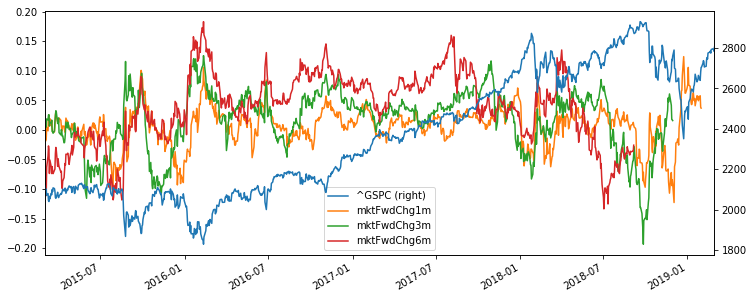

In [16]:
show = [bench_symbol, 'mktFwdChg1m', 'mktFwdChg3m', 'mktFwdChg6m']
secpx[show].tail(252*4).plot(secondary_y=bench_symbol, figsize=(12,5));

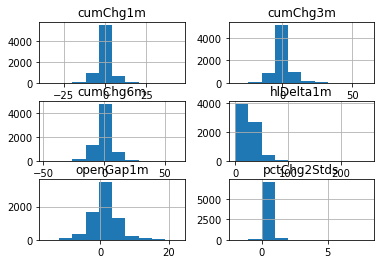

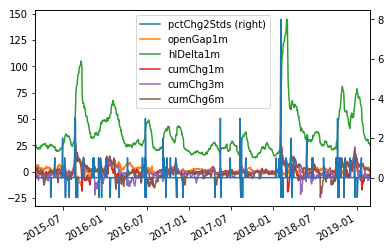

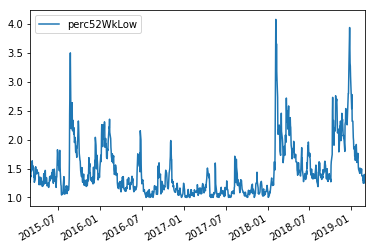

In [17]:
# cumulative deltas and gap analysis
secpx['pctChg2Stds'] = pct_chg.apply(sign_compare, args=(pct_chg.std() * 2,))
secpx['openGap1m'] = (openpx - closepx.shift(1)).rolling(20).sum()
secpx['hlDelta1m'] = (highpx - lowpx).rolling(20).sum()
secpx['cumChg1m'] = (closepx - closepx.shift(1)).rolling(20).sum()
secpx['cumChg3m'] = (closepx - closepx.shift(1)).rolling(60).sum()
secpx['cumChg6m'] = (closepx - closepx.shift(1)).rolling(120).sum()
secpx['perc52WkLow'] = (closepx / closepx.rolling(252).min())

show = ['pctChg2Stds', 'openGap1m', 'hlDelta1m', 
        'cumChg1m', 'cumChg3m', 'cumChg6m']
secpx[show].hist();
secpx[show].tail(252*4).plot(secondary_y='pctChg2Stds');
show = ['perc52WkLow']
secpx[show].tail(252*4).plot();

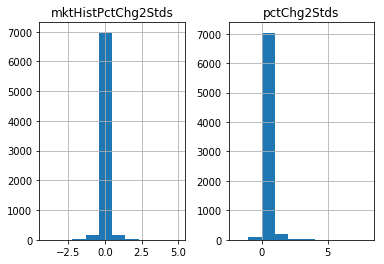

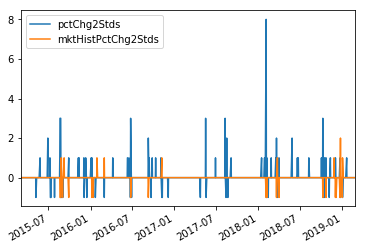

In [18]:
show = ['pctChg2Stds', 'mktHistPctChg2Stds']
secpx[show].hist();
secpx[show].tail(252*4).plot();

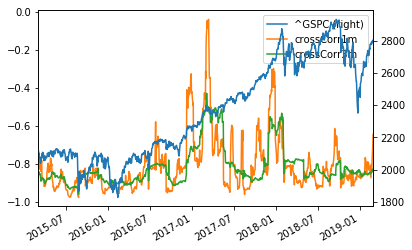

In [19]:
# rolling SPY correlations
secpx['crossCorr1m'] = closepx.pct_change().rolling(20).corr(SPY_pct_chg)
secpx['crossCorr3m'] = closepx.pct_change().rolling(60).corr(SPY_pct_chg)

show = [bench_symbol, 'crossCorr1m', 'crossCorr3m']
secpx[show].tail(252*4).plot(secondary_y=bench_symbol);
# closepx.pct_change().corr(SPY_pct_chg)

In [20]:
secpx.reset_index(inplace=True)
secpx.rename({'index': 'obsDate'}, axis=1, inplace=True)

In [21]:
# remove unnecessary columns
dont_show = ['high', 'open', 'low', bench_symbol]
ml_ds_cols = [x for x in secpx.columns.tolist() if x not in dont_show]
df_raw = secpx[ml_ds_cols].copy()

In [22]:
display_all(df_raw.describe(include='all').T)

,count,unique,top,freq,first,last,mean,std,min,25%,50%,75%,max
obsDate,7348,7348,2017-08-21 00:00:00,1,1990-01-02 00:00:00,2019-03-01 00:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN
^VIX,7348,NaN,NaN,NaN,NaN,NaN,19.2657,7.79183,9.14,13.61,17.4,22.66,80.86
mktHistPctChg2Stds,7348,NaN,NaN,NaN,NaN,NaN,-0.00421884,0.287877,-4,0,0,0,5
mktHistPctChg1m,7328,NaN,NaN,NaN,NaN,NaN,0.00663324,0.0423855,-0.281601,-0.014979,0.0107035,0.0306849,0.234949
mktHistPctChg3m,7288,NaN,NaN,NaN,NaN,NaN,0.0197022,0.0708553,-0.412918,-0.0129274,0.0265908,0.0612788,0.382452
mktHistPctChg6m,7228,NaN,NaN,NaN,NaN,NaN,0.0405754,0.103442,-0.454038,-0.00721451,0.0489221,0.0987654,0.523923
mktPerc52WkLow,7097,NaN,NaN,NaN,NaN,NaN,1.19327,0.116469,1,1.11461,1.17219,1.25598,1.70019
mktFwdChg1m,7328,NaN,NaN,NaN,NaN,NaN,0.00663324,0.0423855,-0.281601,-0.014979,0.0107035,0.0306849,0.234949
mktFwdChg3m,7288,NaN,NaN,NaN,NaN,NaN,0.0197022,0.0708553,-0.412918,-0.0129274,0.0265908,0.0612788,0.382452
mktFwdChg6m,7228,NaN,NaN,NaN,NaN,NaN,0.0405754,0.103442,-0.454038,-0.00721451,0.0489221,0.0987654,0.523923


In [23]:
add_datepart(df_raw, 'obsDate')
df_raw.obsElapsed.head()

0    631238400
1    631324800
2    631411200
3    631497600
4    631756800
Name: obsElapsed, dtype: int64

In [24]:
train_cats(df_raw)

In [25]:
display_all(df_raw.isnull().sum().sort_index()/len(df_raw))

^VIX                   0.000000
crossCorr1m            0.002722
crossCorr3m            0.008165
cumChg1m               0.002722
cumChg3m               0.008165
cumChg6m               0.016331
hlDelta1m              0.002586
mktFwdChg1m            0.002722
mktFwdChg3m            0.008165
mktFwdChg6m            0.016331
mktHistPctChg1m        0.002722
mktHistPctChg2Stds     0.000000
mktHistPctChg3m        0.008165
mktHistPctChg6m        0.016331
mktPerc52WkLow         0.034159
obsDay                 0.000000
obsDayofweek           0.000000
obsDayofyear           0.000000
obsElapsed             0.000000
obsIs_month_end        0.000000
obsIs_month_start      0.000000
obsIs_quarter_end      0.000000
obsIs_quarter_start    0.000000
obsIs_year_end         0.000000
obsIs_year_start       0.000000
obsMonth               0.000000
obsWeek                0.000000
obsYear                0.000000
openGap1m              0.002722
pctChg2Stds            0.000000
perc52WkLow            0.034159
dtype: f

In [26]:
os.makedirs('tmp', exist_ok=True)
df_raw.to_feather('tmp/macro-vix-raw')

### Pre-processing

In [27]:
df_raw = pd.read_feather('tmp/macro-vix-raw')

### Local training using RandomForest

In [226]:
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from sklearn import metrics

In [227]:
ds_name = 'ds_macro_vix_'
update_fmt = 'Added {} to {} dataset'
class_cols = ['mktFwdChg1m', 'mktFwdChg3m', 'mktFwdChg6m']
cut_range = [-1, -0.1, .0, .02, .1, 1.]
fwd_ret_labels = ["bear", "short", "neutral", "long", "bull"]

In [241]:
ml_ds_df.dropna(inplace=True)

In [242]:
m = RandomForestRegressor(n_jobs=-1)
%time m.fit(ml_ds_df.drop(class_cols, axis=1), ml_ds_df[class_cols[0]])


/Users/vveiga/miniconda3/envs/inception/lib/python3.7/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


CPU times: user 1 s, sys: 7 ms, total: 1.01 s
Wall time: 213 ms


RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=-1,
           oob_score=False, random_state=None, verbose=0, warm_start=False)

### Visualization

In [ ]:
# show correlations with Y variables
show = ['mktFwdChg1m', 'mktFwdChg3m', 'mktFwdChg6m']
ml_ds_df.corr()[show]

In [ ]:
# series distributions
%time ml_ds_df.hist(figsize=(15,15));

In [ ]:
# scatter plots
%time pd.plotting.scatter_matrix(ml_ds_df, alpha=0.1, figsize=(40, 40));

### Discretize forward returns into classes

In [ ]:

for c in class_cols:  ml_ds_df[c] = pd.cut(
    ml_ds_df[c], cut_range, labels=fwd_ret_labels)

### Save datasets with dependent variable into S3

In [ ]:
# Split into different datasets with Y at the end, save in S3
Xs = [x for x in ml_ds_cols if x not in class_cols]
for y in class_cols:
    ds_cols = Xs + [y] # join Xs and Y
    fname = ds_name + y # dataset name
    # drop nas and shuffle the data    
    ml_ds_df_y = ml_ds_df[ds_cols].dropna().sample(frac=1)
    csv_store(ml_ds_df_y, 'training/', csv_ext.format(fname))
    print(update_fmt.format(len(ml_ds_df_y), fname))

In [ ]:
# last uploaded dataset
ml_ds_df_y.info()

In [ ]:
# get prediction record
class_cols = ['mktFwdChg1m', 'mktFwdChg3m', 'mktFwdChg6m']
record = ml_ds_df.drop(columns=class_cols).iloc[-1]
record, record.values

### Other code

In [ ]:
# quick overview on statistically significnat pct moves
# pd.value_counts(secpx['pct_chg_std']).sort_index()
# secpx['pct_chg_std'][secpx['pct_chg_std'] > 15]
# secpx.loc['2018-02',:]